# Analyzing the ADAM optimizer for phase retrieval applications

## The phase retrieval problem


Consider a $2D$ array of $N\times N$ complex numbers $z_{ij}$. By applying a two-dimensinal discrete fourier transform to this array, we can transform the complex numbers $z_{ij}$ to another $N\times N$ array of complex numbers $Z_{kl}$. This can be written as 
$$ \mathbf{Z} = F(\mathbf{z}),$$
where $F$ represents the two-dimensional DFT. 

Often, in signal-processing experiments, we measure the modulus of transformed array, ie $|\mathbf{Z}|$, from which we are asked to reconstruct the original signal $\mathbf{z}$. Usually, we already know part of the original signal, and only need to solve for sub-block of $\mathbf{z}$. This problem requires that we solve for the phase of the transformed signal $\mathbf{Z}$ using the modulus $|\mathbf{Z}|$, and is hence known as the "phase retrieval problem". The already known part of the original (untransformed) signal is called the "support".

## The gradient descent approach

To solve the phase retrieval problem, we can formulate a loss function
$$f (\mathbf{z}_{guess}) = \sum{\left(|F(\mathbf{z}_{guess}| - |\mathbf{Z}|\right)^2},$$
where $|{Z}|$ is the measured data and $\mathbf{z}_{guess}$ includes both the unknown variables and the known support. By minimizing the value of loss function $f(\mathbf{z}_{guess})$, we can solve for the unknown variables (and hence the phase of the measurement).

For this final project, I write the code for the ADAM optimizer to minimize this loss function. Additionally, to analyze the performance of ADAM, I also write the code for a backtracking adaptive gradient descent algorithm. 

To calculate the complex gradients, I use the Wirtinger derivative formulation. According to this formulation, the complex gradient of a real-valued function $f$ is defined as:
$$\nabla f(z) = \frac{1}{2}\left(\frac{df}{dx} + i\frac{df}{dy}\right)$$
where $z=x+iy$, with $x, y \in \mathbb{R}$.

The ADAM optimizer is described in:

https://arxiv.org/pdf/1412.6980.pdf

The backtracking adaptive gradient method is described in:

*Machine Learning Refined: Foundations, Algorithms, and Applications*, by Watt, Borhani, and Kastaggelos. 

The Wirtinger derivative is described in:

https://people.eecs.berkeley.edu/~stephentu/blog/complex-analysis/2016/04/14/complex-differentiation.html

**Note**: 

I was unable to calculate the Lipschitz constant of the gradient for the cost function presented above. As a consequence, I am using an arbitrary step size which seems to work well for both the ADAM and adaptive gradient methods. The standard gradient descent method, however, frequently blows up for this choice of step size.

### Methods:
1) For my original signal, I use the standard moon and camera images (from the skimage python library) as the real and imagninary parts respectively. I rescale the original images to $128 \times 128$ pixels.

2) I use a sub-block of the original signal as my unknowns. I initialize this sub-block as random complex numbers. The remaining section of the original signal is the "support".

In [52]:
from autograd import numpy as np
from autograd import grad
import matplotlib.pyplot as plt
import skimage, skimage.transform, skimage.data
import abc

In [53]:
class Optimizer:
    """A generic gradient descent optimizer class. Adam and Adaptive gradient descent are both derived from here."""
    def __init__(self, loss_function, learning_rate, init_weights, verbose=False):
        """Parameters:
        
        loss_function - function to minimize
        
        learning_rate - the initial step size for the gradient descent
        
        init_weights - the initial values for the variables
        
        """
        self.verbose = verbose
        self.epoch = 0
        self._loss_function = loss_function
        self.loss_function_counter = 0
        
        self.learning_rate = learning_rate
        
        # Only accepts numpy array as input for weights
        assert(type(init_weights) is np.ndarray), "Weights should be initialized as a numpy array"
        self.weights = init_weights.copy()
        
        # For functions of complex variables, use Wirtinger gradient descent
        if init_weights.dtype in [np.complex64, np.complex128]:
            self._grad_function = lambda z: 0.5 * np.conjugate(grad(loss_function)(z))
        else:
            self._grad_function = grad(loss_function)
        self.grad_function_counter = 0
        
        self.losses = []
    
    @property
    def loss_function(self):
        """To count the number of loss function calls"""
        self.loss_function_counter += 1
        return self._loss_function
    
    @property
    def grad_function(self):
        """To count the number of gradient calls"""
        self.grad_function_counter += 1
        return self._grad_function
        
    @abc.abstractmethod
    def minimizeSingleEpoch(self):
        """Abstract method. Replaced in derived classes."""
        pass

    def checkTolerance(self, lossval, gradvals, abs_tol, rel_tol):
        """The optimizer stops when:
        1) The value of the loss function is smaller than the set absolute tolerance.
        
        2) The maximum absolute value in the array of gradients is smaller than the relative tolerance
        
        """
        losscheck = lossval < abs_tol
        gradcheck = np.max(np.abs(gradvals)) < rel_tol
        if losscheck or gradcheck:
            if self.verbose:
                print('Rel tolerance', gradcheck)
                print('Abs tolerance', losscheck)
            return True
        return False

    def minimize(self, num_epochs, abs_tol=1e-6, rel_tol=1e-4):
        """Uses minimizeSingleEpoch to run the minimization a given number of times.
        
        Uses checkTolerance to stop early if the tolerances are satisfied."""
        
        lossval = self.loss_function(self.weights)
        gradvals = self.grad_function(self.weights)
        self.losses.append(lossval)
        
        if self.checkTolerance(lossval, gradvals, abs_tol, rel_tol):
            return self.weights

        for i in range(num_epochs):
            gradvals = self.minimizeSingleEpoch()
            lossval = self.loss_function(self.weights)
            self.losses.append(lossval)
            
            if self.checkTolerance(lossval, gradvals, abs_tol, rel_tol):
                return self.weights
            
        return self.weights
        

In [54]:
class AdamOptimizer(Optimizer):
    def __init__(self, *args, beta1=0.9, beta2=0.999, epsilon=1e-8):
        """beta1 and beta2 are the coefficients for the first and second moment respectively."""
        super().__init__(*args)
        
        assert( 0 <= beta1 < 1), "Beta1 should be within [0,1)"
        assert( 0 <= beta2 < 1), "Beta2 should be within [0, 1)"
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        
        self.first_moment = 0
        self.second_moment = 0
        self.learning_rate_current = 0
        
    def minimizeSingleEpoch(self):
        self.epoch += 1
        gradvals = self.grad_function(self.weights)

        self.first_moment = self.beta1 * self.first_moment + (1 - self.beta1) * gradvals
        self.second_moment = self.beta2 * self.second_moment + (1 - self.beta2) * np.abs(gradvals)**2
        
        self.learning_rate_current = (self.learning_rate * np.sqrt(1 - self.beta2 ** self.epoch) / 
                                      (1 - self.beta1 ** self.epoch))
        self.weights = self.weights - (self.learning_rate_current * self.first_moment / 
                                       (np.sqrt(self.second_moment) + self.epsilon))
        return gradvals

In [55]:
class AdaptiveGradientDescentOptimizer(Optimizer):
    def __init__(self, *args, damping_factor=0.95):
        super().__init__(*args)
        self.damping_factor = damping_factor
    
    def backtrackingSearch(self, gradvals):
        alpha_k = self.learning_rate
        lossval = self.losses[-1]
        condition = True
        while condition:
            left = self.loss_function(self.weights - alpha_k * gradvals)
            right = lossval - alpha_k / 2 * np.sum(np.linalg.norm(gradvals)**2)
            alpha_k = self.damping_factor * alpha_k
            condition = left > right
        return alpha_k
        
    def minimizeSingleEpoch(self):
        self.epoch += 1
        
        gradvals = self.grad_function(self.weights)
        learning_rate_current = self.backtrackingSearch(gradvals)
        self.weights = self.weights - learning_rate_current * gradvals
        return gradvals

 Once we have the optimizers defined, we need to now define the loss functions, the variables, and the supports.

In [56]:
def forwardTransform(x):
    """Wrapper for the 2d-fft."""
    return np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(x))))

In [57]:
def lossFunction(x, img_support, ft_mod):
    """Takes subblock of variables, adds the support, then calculates the loss."""
    x1 = np.fft.truncate_pad(x, (img_support.shape[0], img_support.shape[0]))
    x2 = x1 + img_support
    loss = np.sum((forwardTransform(x2) - ft_mod)**2 / x.size)
    return loss

In [58]:
def getSkimageData(scale_factor=1):
    """Get initial images from skimage."""
    arrdata = lambda x: skimage.img_as_float(skimage.color.rgb2gray(x))[::-1, ::-1]
    real = skimage.transform.rescale(arrdata(skimage.data.moon()), scale_factor, preserve_range=True)
    imag = skimage.transform.rescale(arrdata(skimage.data.camera()), scale_factor, preserve_range=True) #* 2 * np.pi
    return real + 1j * imag#mod * np.exp(1j * phase)

In [59]:
def runOptimization(optimizer, image_true, img_support, n_steps, rel_tol=1e-4, abs_tol=1e-6):
    """Runs the actual minimization, then calculates the error in the signal reconstruction."""
    optimizer.minimize(n_steps, rel_tol, abs_tol)
    image_new = np.fft.truncate_pad(optimizer.weights, (image.shape[0], image.shape[0]))
    image_new = image_new + img_support
    
    error = np.mean(np.abs(image_true - image_new))
    return image_new, error, optimizer.grad_function_counter + optimizer.loss_function_counter

The next cell shows the ground truth for the real part, the imaginary part, and the modulus of the fourier transform.

/home/saugat/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


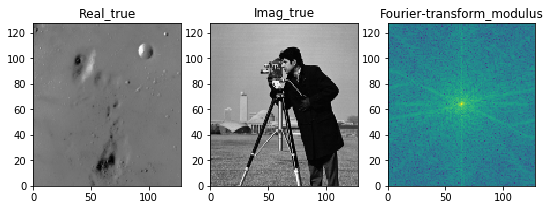

In [60]:
image = getSkimageData(1/4)
ft_mod = forwardTransform(image)
plt.figure(figsize=[9,3])
figs = { 'Real_true':np.real(image), 'Imag_true':np.imag(image)}
for i, (key, val) in enumerate(figs.items()):
    plt.subplot(1,3,i+1)
    plt.pcolormesh(val, cmap='gray')
    plt.title(key)
plt.subplot(1, 3, 3)
plt.pcolormesh(np.log(ft_mod))
plt.title('Fourier-transform_modulus')
plt.show()


In the next cell, I demonstrate a sample use of the Adam optimizer. I use a subblock of $50\times 50$ pixels as my variables, the remaining pixels as my support, and the previously calculated fourier modulus  as my data points.

The two images on the left show the support, where the black blocks on the lower left show the $50\times 50$ complex variables I am solving for.

The two images on the right show the reconstructed image after the minimization step.

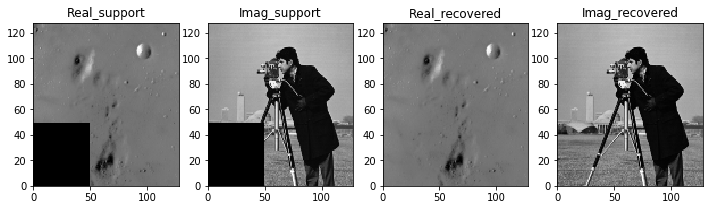

In [61]:
sample_support = image.copy()
sample_support[:50, :50] = 0
n_steps = 1000
lossfn = lambda x: lossFunction(x, sample_support, ft_mod)

init_weights = np.zeros((50,50)).astype('complex64')
adam = AdamOptimizer(lossfn, 0.5, init_weights)
image_new, adam_error, adam_fft_counter = runOptimization(adam, image, sample_support, n_steps)

plt.figure(figsize=[12,3])
figs = {'Real_support':np.real(sample_support), 'Imag_support':np.imag(sample_support),
        'Real_recovered':np.real(image_new), 'Imag_recovered':np.imag(image_new)}
for i, (key, val) in enumerate(figs.items()):
    plt.subplot(1,4,i+1)
    plt.pcolormesh(val, cmap='gray')
    plt.title(key)
plt.show()

An effective method to compare the computational efficiency of the presented gradient descent methods is to calculate the number of gradient and loss function calls. The larger the number of calls before convergence, the higher the computational cost.

In [67]:
n_steps =  10000

print('num_vars \t Adam_err \t Adam_ncalls \t Adaptive_err \t Adaptive_ncalls')
for n_vars_per_dim in [10, 20, 30, 40, 50, 60, 70]:
    img_support = image.copy()
    img_support[:n_vars_per_dim, :n_vars_per_dim] = 0
    
    random_vals = np.random.randn(2, n_vars_per_dim, n_vars_per_dim)
    init_weights = random_vals[0] + 1j * random_vals[1]
    
    lossfn = lambda x: lossFunction(x, img_support, ft_mod)
    
    print(n_vars_per_dim**2, end='\t')
    for optimizer_class in [AdamOptimizer, AdaptiveGradientDescentOptimizer]:
        opt = optimizer_class(lossfn, 0.5, init_weights)
        newimg, error, counter = runOptimization(opt, image, img_support, n_steps)
        print(error, '\t', counter, end='\t')
    print()

num_vars 	 Adam_err 	 Adam_ncalls 	 Adaptive_err 	 Adaptive_ncalls
100	5.43321065821e-07 	 348	4.44348371427e-07 	 700	
400	2.31735452784e-06 	 354	8.70121938303e-07 	 502	
900	5.38973967574e-06 	 354	2.84585596915e-06 	 353	
1600	1.03092223124e-05 	 356	8.84179781947e-06 	 301	
2500	1.62756036926e-05 	 354	2.84906733546e-05 	 269	
3600	0.00134428905507 	 670	0.00115281103864 	 906	
4900	0.0118225807149 	 1074	0.0128034540076 	 3360	


### Conclusion
As we can see above, for this arbitrary choice of learning rate and damping constant (for the adaptive method), we find that the ADAM method is always more efficient than the adaptive line search method. While this might not hold true if we choose the damping constant carefully for the different number of variables, it seems that ADAM is a much better choice for out-of-the-box gradient descent.